<a href="https://colab.research.google.com/github/AdithyaSrivastava01/CIFAR10/blob/main/CIFAR10Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url 
from torch.utils.data import random_split
from torch.utils.data import DataLoader


In [ ]:
url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url,'.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
import tarfile

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path="./data")#path gives where the extracted data must go

In [ ]:
import os

In [ ]:
path="./data/cifar10/"
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))#normalizing based on the mean and the variance
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), #randomly crops a segment of image after adding padding 
                                                                               #Pads the input tensor using the reflection of the input boundary.
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
#includes both data augmentation and channel normalization
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])#composes all the image transform into one transform 

In [ ]:
train_ds=ImageFolder(path+"train",train_tfms)#calls the transform function to change the neccessary changes.
#print(*train_ds[0])
test_ds=ImageFolder(path+"test",test_tfms)

In [ ]:
len(train_ds)

50000

In [ ]:
len(test_ds)

10000

In [ ]:
batch_size=400

In [ ]:
#to make the image in [0,1] range we make the means and stds into tensor of batch and 3 channels and pixel of 1px and 1px of height and weight.
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

In [ ]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4, pin_memory=True)#num_workers and pin_memory makes sure that the no. of cores of the cpu are being used

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_dl=DataLoader(test_ds,batch_size)#num_workers and pin_memory makes sure that the no. of cores of the cpu are being used

In [ ]:
#The Model which we will be incorporating is the ResNet9 with many repetitive layers.

In [ ]:
list=[3,5,2,7]
print(*list,sep=",")

3,5,2,7


In [ ]:
import torch.nn as nn
import torch.nn.functional as F 

In [ ]:
def conv2d(inp,out,pool=False):
  layers=[nn.Conv2d(inp,out,kernel_size=3,padding=1),nn.BatchNorm2d(out),nn.ReLU(inplace=True)]
  if(pool):
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [ ]:
class ResNet9Model(nn.Module):
  def __init__(self,inp,out):
    super().__init__()
    self.conv1=conv2d(inp,64)
    self.conv2=conv2d(64,128,pool=True)
    self.res1=nn.Sequential(conv2d(128,128),conv2d(128,128))
    self.conv3 = conv2d(128, 256, pool=True)
    self.conv4 = conv2d(256, 512, pool=True)
    self.res2 = nn.Sequential(conv2d(512, 512), conv2d(512, 512))

    self.classifier=nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512,out)

    )
  def forward(self,xb):
    out=self.conv1(xb)
    out=self.conv2(out)
    out=self.res1(out)+out
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.res2(out)+out
    out=self.classifier(out)
    
    return out







In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
input_channels=3
num_classes=10
model=ResNet9Model(input_channels,num_classes).to(device)
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn=F.cross_entropy
#model

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
def train(epochs, max_lr, model, train_dl,loss_fn,weight_decay=0, grad_clip=None,opt=torch.optim.SGD):
  torch.cuda.empty_cache()
  model.train()
  # Set up cutom optimizer with weight decay
  opt= opt(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))
  for i in range(epochs):
    for image,label in train_dl:
      image,label=image.to(device),label.to(device)
      pred=model(image)
      loss=loss_fn(pred,label)
      loss.backward()
      # Gradient clipping
      if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
      opt.step()
      opt.zero_grad()

      sched.step()
    print("Epoch: ",i," completed")


In [ ]:
train(epochs, max_lr, model, train_dl, loss_fn,weight_decay=weight_decay, grad_clip=grad_clip,opt=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:  0  completed
Epoch:  1  completed
Epoch:  2  completed
Epoch:  3  completed
Epoch:  4  completed
Epoch:  5  completed
Epoch:  6  completed
Epoch:  7  completed


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy=[]
with torch.no_grad():
  model.eval()

  for img,label in test_dl:
    img,label=img.to(device),label.to(device)
    pred=model(img)
    probs=F.softmax(pred,dim=1)
    max_prob,preds=torch.max(probs,dim=1)
    preds=preds.cpu().numpy()
    label=label.cpu().numpy()
    accuracy+=[accuracy_score(preds,label)]



In [ ]:
print(len(accuracy))
accuracy_net=((sum(accuracy))/(len(accuracy)))*100
print("the net accuracy of model is: ",accuracy_net,"%")

25
the net accuracy of model is:  90.83000000000001 %


In [ ]:
#print(*test_dl)


In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [ ]:
len(test_dl)

25

In [ ]:
img, label=test_ds[600]
print(img.shape)
test_new=test_ds.classes
#img=ToTensor(img)
with torch.no_grad():
    model.eval()
    pred = model(img.to(device).unsqueeze(0))
    probs=F.softmax(pred,dim=1)
    
    max_probs, preds = torch.max(probs, dim=1)
    print(test_new[preds])
    print(max_probs.item())
    print(test_new[label])
print(img.shape)

torch.Size([3, 32, 32])
airplane
0.999996542930603
airplane
torch.Size([3, 32, 32])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
img.shape

torch.Size([3, 32, 32])

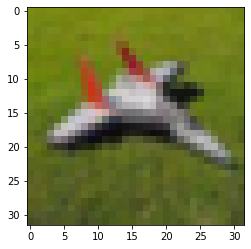

In [ ]:
img_new=denormalize(img,*stats)
plt.imshow(img_new.permute(1,2,0))